In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
from collections import Counter
import math
import re
import json
import subprocess
import time
import pickle

import pandas as pd
import umap
from tqdm.autonotebook import tqdm, trange
from nltk.tokenize import word_tokenize

import numpy as np
import scipy.stats
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.utils import class_weight

from tensorflow import keras

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
#assert gpus
try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
layers = keras.layers
models = keras.models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy.random as rng
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

import convert_model

import language
import text_nn
import grab_category
import news
import groups
import libs.cpp_stuff as cpp

In [3]:
lang = "en"
train_folders = [os.path.join("data", folder) for folder in ["sample", "sample3", "sample4", "sample5", "sample6"]]
test_folders = [os.path.join("data", folder) for folder in ["sample2"]]
idf_file = groups.counts_for_grouping_ru if lang == "ru" else groups.counts_for_grouping_en
cpp.load_idf(idf_file)

def load_dataset(folders):
    all_file_info = []
    all_similarities = []
    for folder in tqdm(folders):
        for cat in ["society", "economy", "sports", "science", "other", "technology", "entertainment"]:
            file_info = language.read_dump(f"{folder}/categories_{lang}/{cat}")
            processed_texts = groups.extract_texts_for_grouping(file_info)
            all_similarities.extend(cpp.calc_popularities([(pt, fi.site, fi.file, groups.parse_datetime(fi.time).timestamp())
                                                           for pt, fi in zip(processed_texts, file_info)], idf_file))
            
            all_file_info.extend(file_info)
            
    return all_file_info, all_similarities

train_file_info, train_similarities = load_dataset(train_folders)
test_file_info, test_similarities = load_dataset(test_folders)
print(f"{len(train_file_info)} train samples, {len(test_file_info)} test")


300319 train samples, 31440 test


In [4]:
normalizer = news.TextNormalizer(lang)
normalizer.train(train_file_info)
train_texts = normalizer.normalize_texts(train_file_info)
test_texts = normalizer.normalize_texts(test_file_info)

73009 word stems


In [5]:
with open(os.path.join(f"data/popularities_{lang}"), "wb") as f:
    pickle.dump((train_texts, train_similarities, test_texts, test_similarities), f)

In [6]:
def calc_popularity(similarities):
    return scipy.stats.zscore(np.log1p(similarities))

train_popularity = calc_popularity(train_similarities)
test_popularity = calc_popularity(test_similarities)

In [7]:
top_news = list(sorted(range(len(train_popularity)), key=lambda x: train_popularity[x], reverse=True))
for i in top_news[:3]:
    print(f"{train_popularity[i]}\n\t{train_file_info[i].text[:400]}")
    print()

5.453215534117395
	Russia reports spike in coronavirus cases as other countries ease restrictions Russia has reported its highest one-day jump in new coronavirus cases as some other countries relax lockdown restrictions. China, where the pandemic began in December, reported a single new infection on Saturday, extending a steady decline in confirmed cases. The country has allowed factories and some other businesses t

5.357112083830893
	Russia reports spike in coronavirus cases as other countries ease restrictions Russia’s government reported 7,933 new cases on Friday, raising its total to 114,431. Russia has reported its highest one-day jump in new coronavirus cases as some other countries relax lockdown restrictions. China, where the pandemic began in December, reported a single new infection on Saturday, extending a steady dec

5.3532467658509235
	Russia reports spike in coronavirus cases as other countries ease restrictions Russia’s government reported 7,933 new cases on Friday, rai

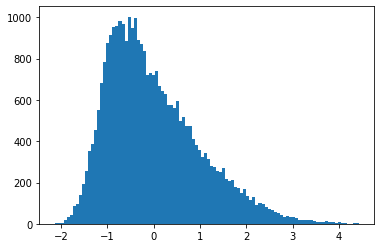

In [8]:
x = plt.hist(test_popularity, bins=100)

In [9]:
verbose = 1
max_words = 7000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_texts)  # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_texts).astype(np.float32)
x_test = tokenize.texts_to_matrix(test_texts).astype(np.float32)

In [10]:
%reset -f in out
batch_size = 32
epochs = 100
drop_ratio = 0.5
reg = 0.01

# Build the model
model = models.Sequential()
model.add(layers.Dropout(drop_ratio, input_shape=(max_words,)))
model.add(layers.Dense(512, use_bias=True, activation="relu", kernel_regularizer=regularizers.l2(reg)))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(512, use_bias=True, activation="relu", kernel_regularizer=regularizers.l2(reg)))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(1, use_bias=True, kernel_regularizer=regularizers.l2(reg)))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0001), metrics=['mean_squared_error'])

model.summary()

Flushing input history
Flushing output cache (0 entries)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 7000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3584512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 3,847,681
Trainable params: 3,847,681
Non-trainable

In [11]:
sample_weights = np.ones_like(train_popularity)
sample_weights[train_popularity < -1] = 0.1
sample_weights[train_popularity > 0] = 2
sample_weights[train_popularity > 1] = 5
mcp_save = ModelCheckpoint(f'data/ranking_model_{lang}.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(x_train, train_popularity,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    #sample_weight=sample_weights,
                    validation_data=(x_test, test_popularity),
                    callbacks=[mcp_save])

model.load_weights(f'data/ranking_model_{lang}.h5')

Train on 300319 samples, validate on 31440 samples
Epoch 1/100
300319/300319 [==============================] - 39s 128us/sample - loss: 1.9763 - mean_squared_error: 0.6735 - val_loss: 0.8839 - val_mean_squared_error: 0.6071
Epoch 2/100
300319/300319 [==============================] - 38s 126us/sample - loss: 0.8578 - mean_squared_error: 0.5867 - val_loss: 0.8987 - val_mean_squared_error: 0.6339
Epoch 3/100
300319/300319 [==============================] - 38s 128us/sample - loss: 0.8390 - mean_squared_error: 0.5769 - val_loss: 0.8780 - val_mean_squared_error: 0.6243
Epoch 4/100
300319/300319 [==============================] - 38s 127us/sample - loss: 0.8257 - mean_squared_error: 0.5721 - val_loss: 0.8531 - val_mean_squared_error: 0.6000
Epoch 5/100
300319/300319 [==============================] - 38s 127us/sample - loss: 0.8195 - mean_squared_error: 0.5719 - val_loss: 0.8381 - val_mean_squared_error: 0.5943
Epoch 6/100
300319/300319 [==============================] - 38s 126us/sample -

In [12]:
predicted_popularity = model.predict(x_test, verbose=0)
sample = np.random.choice(len(test_popularity), 10000)
print(np.corrcoef(test_popularity[sample], predicted_popularity[sample, 0]))
very_popular = np.flatnonzero(test_popularity > 0.5)
print(np.corrcoef(test_popularity[very_popular], predicted_popularity[very_popular, 0]))

[[1.        0.6710555]
 [0.6710555 1.       ]]
[[1.         0.40257288]
 [0.40257288 1.        ]]


In [13]:
top_news = list(sorted(range(len(predicted_popularity)), key=lambda x: predicted_popularity[x], reverse=True))
for i in top_news[:30]:
    print(f"{predicted_popularity[i]} {test_popularity[i]}\n\t{test_file_info[i].text[:400]}")
    print()

[2.7371147] 3.6732041244154225
	US diplomat acknowledges what Democrats call a quid pro quo WASHINGTON (AP) - I now do recall. WASHINGTON (AP) - "I now do recall." With that stunning reversal, diplomat Gordon Sondland handed House impeachment investigators another key piece of corroborating testimony Tuesday. He acknowledged what Democrats contend was a clear quid pro quo, pushed by President Donald Trump and his personal lawyer

[2.7222633] 2.3322680503003483
	U.S. diplomat acknowledges what Democrats call a quid pro quo WASHINGTON -- "I now do recall." With that stunning reversal, diplomat Gordon Sondland handed House impeachment investigators another key piece of corroborating testimony Tuesday. He acknowledged what Democrats contend was a clear quid pro quo, pushed by President Donald Trump and his personal lawyer, Rudy Giuliani, with Ukraine. Sondla

[2.581759] 2.1032697053215132
	Impeachment reversal: Diplomat now acknowledges quid pro quo WASHINGTON -- "I now do recall." With th

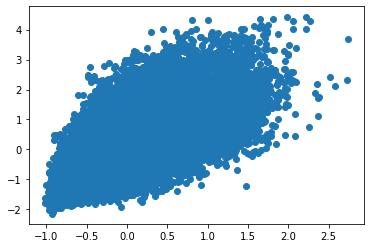

In [14]:
plt.scatter(predicted_popularity, test_popularity)

In [15]:
model.load_weights(f'data/ranking_model_{lang}.h5')
model.save(f'data/keras_model_{lang}.h5', include_optimizer=False)
convert_model.convert(f"data/keras_model_{lang}.h5", f"data/ranking_model_{lang}.json", no_tests=False)

tokenizer_data = json.loads(tokenize.to_json())
word_index = json.loads(tokenizer_data["config"]["word_index"])
with open(f"data/ranking_dictionary_{lang}.tsv", "w") as f:
    for word, index in word_index.items():
        if index < max_words:
            f.write(f"{word}\t{index}\t{normalizer.idf[word] if word in normalizer.idf else 0}\n")

loading data/keras_model_en.h5
Forward pass took 0.052549 s.
Forward pass took 0.025113 s.
Forward pass took 0.024427 s.
Starting performance measurements.
Forward pass took 0.025026 s.
Forward pass took 0.024218 s.
Forward pass took 0.025282 s.
Forward pass took 0.026868 s.
Forward pass took 0.021642 s.
Forward pass took 0.024607200000000003 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing data/ranking_model_en.json


In [16]:
cpp_preds = news.run_nn(test_file_info[:10000], lang, f"data/ranking_model_{lang}.json", f"data/ranking_dictionary_{lang}.tsv")

In [17]:
cpp_preds = np.array(cpp_preds)
np.corrcoef(predicted_popularity[:10000, 0], cpp_preds[:, 0])

array([[1., 1.],
       [1., 1.]])

In [18]:
top_news = list(sorted(range(len(cpp_preds)), key=lambda x: cpp_preds[x], reverse=True))
for i in top_news[:30]:
    print(f"{cpp_preds[i]} {test_popularity[i]}\n\t{test_file_info[i].text[:400]}")
    print()

[2.73711467] 3.6732041244154225
	US diplomat acknowledges what Democrats call a quid pro quo WASHINGTON (AP) - I now do recall. WASHINGTON (AP) - "I now do recall." With that stunning reversal, diplomat Gordon Sondland handed House impeachment investigators another key piece of corroborating testimony Tuesday. He acknowledged what Democrats contend was a clear quid pro quo, pushed by President Donald Trump and his personal lawyer

[2.72226381] 2.3322680503003483
	U.S. diplomat acknowledges what Democrats call a quid pro quo WASHINGTON -- "I now do recall." With that stunning reversal, diplomat Gordon Sondland handed House impeachment investigators another key piece of corroborating testimony Tuesday. He acknowledged what Democrats contend was a clear quid pro quo, pushed by President Donald Trump and his personal lawyer, Rudy Giuliani, with Ukraine. Sondla

[2.5817585] 2.1032697053215132
	Impeachment reversal: Diplomat now acknowledges quid pro quo WASHINGTON -- "I now do recall." With

In [19]:
site_popularity = {}
for fi, pop in zip(train_file_info, train_popularity):
    if fi.site not in site_popularity:
        site_popularity[fi.site] = []
        
    site_popularity[fi.site].append(pop)
    
for site, pops in site_popularity.items():
    site_popularity[site] = (sum(pops) / len(pops)) if len(pops) > 50 else None
    
for site in list(site_popularity.keys()):
    if site_popularity[site] is None:
        del site_popularity[site]
    
with open(f"data/site_popularity_{lang}.tsv", "w") as f:
    for site, pop in sorted(site_popularity.items(), key=lambda x: x[1], reverse=True):
        f.write(f"{site}\t{pop}\n")